In [ ]:
!pip install music21
!apt-get install -y lilypond
!pip install lilypond

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  dvisvgm fonts-droid-fallback fonts-lmodern fonts-noto-mono fonts-urw-base35 ghostscript
  libfontenc1 libgs9 libgs9-common libidn12 libijs-0.35 libjbig2dec0 libkpathsea6 libptexenc1
  libsynctex2 libteckit0 libtexlua53 libtexluajit2 libwoff1 libzzip-0-13 lilypond-data
  lilypond-fonts lmodern poppler-data t1utils tex-common texlive-base texlive-binaries
  texlive-latex-base xfonts-encodings xfonts-utils
Suggested packages:
  fonts-noto fonts-freefont-otf | fonts-freefont-ttf fonts-texgyre ghostscript-x lilypond-doc
  python3-lxml poppler-utils fonts-japanese-mincho | fonts-ipafont-mincho fonts-japanese-gothic
  | fonts-ipafont-gothic fonts-arphic-ukai fonts-arphic-uming fonts-nanum debhelper perl-tk xpdf
  | pdf-viewer xzdec texlive-latex-base-doc
The following NEW packages will be installed:
  dvisvgm fonts-droid-fallback fonts-lmodern

In [ ]:
#Importing Libraries
import tensorflow
import numpy as np
import pandas as pd
from collections import Counter
import random
import IPython
from IPython.display import Image, Audio
import music21
from music21 import *
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adamax
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline
import sys
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")
np.random.seed(42)

In [ ]:
# Specify the directory containing the MIDI files
midi_directory = r'/content/drive/MyDrive/Input/classical-music-midi/chopin'


In [ ]:
# Getting midi files
import os
all_midis = []
for filename in os.listdir(midi_directory):
    if filename.endswith(".mid"):
        midi_path = os.path.join(midi_directory, filename)
        midi = converter.parse(midi_path)
        all_midis.append(midi)

In [ ]:
def extract_notes(file):
    notes = []
    pick = None
    for j in file:
        songs = instrument.partitionByInstrument(j)
        for part in songs.parts:
            pick = part.recurse()
            for element in pick:
                if isinstance(element, note.Note):
                    notes.append(str(element.pitch))
                elif isinstance(element, chord.Chord):
                    notes.append(".".join(str(n) for n in element.normalOrder))

    return notes

In [ ]:
#Getting the list of notes as Corpus
Corpus= extract_notes(all_midis)
print("Total notes in all the Chopin midis in the dataset:", len(Corpus))
print("First fifty values in the Corpus:", Corpus[:50])


Total notes in all the Chopin midis in the dataset: 57894
First fifty values in the Corpus: ['B-3', 'B-2', '9.10', '9.10', '1.5', '1.5', '1.5', '1.5', '9.10', '9.10', '1.5', '1.5', 'B-3', '10', '6.10', '10.0.3.6', '6.10', '10.0.3.6', '0.3', '10.0.3.6', '0.5', '10.0.3.6', '0.6', '10.0.3.6', '1.5', '10.1.5', '9.10', '9.10', '1.5', '1.5', '1.5', '1.5', '9.10', '9.10', '1.5', '1.5', 'G#3', '8', '1.5.8', '5.8', '1.5.8', '5.8', '1.5.8', '0.3', '3.6.8', '0.5', '3.6.8', '0.6', '3.6.8', '1.5']


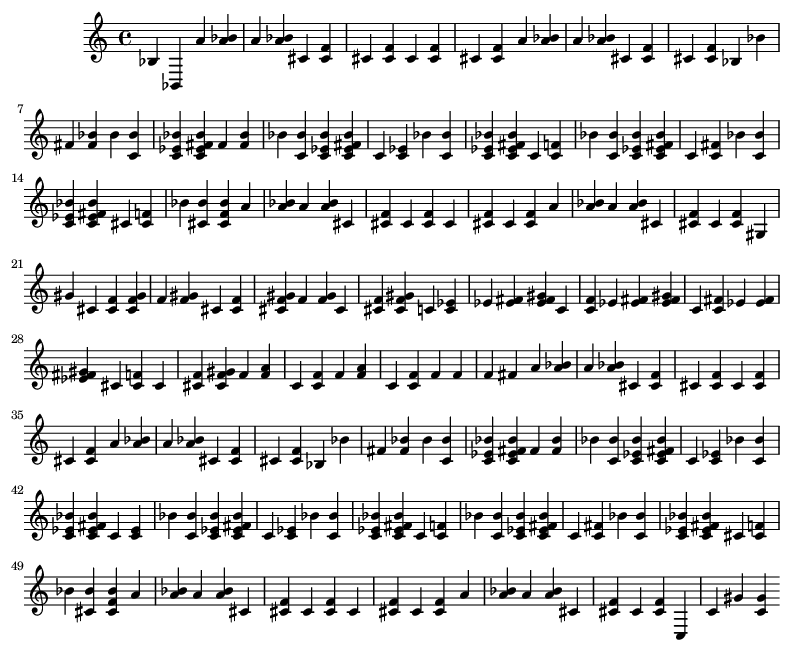

In [ ]:
#First Lets write some functions that we need to look into the data
def show(music):
    display(Image(str(music.write("lily.png"))))

def chords_n_notes(Snippet):
    Melody = []
    offset = 0 #Incremental
    for i in Snippet:
        #If it is chord
        if ("." in i or i.isdigit()):
            chord_notes = i.split(".") #Seperating the notes in chord
            notes = []
            for j in chord_notes:
                inst_note=int(j)
                note_snip = note.Note(inst_note)
                notes.append(note_snip)
                chord_snip = chord.Chord(notes)
                chord_snip.offset = offset
                Melody.append(chord_snip)
        # pattern is a note
        else:
            note_snip = note.Note(i)
            note_snip.offset = offset
            Melody.append(note_snip)
        # increase offset each iteration so that notes do not stack
        offset += 1
    Melody_midi = stream.Stream(Melody)
    return Melody_midi

Melody_Snippet = chords_n_notes(Corpus[:100])
show(Melody_Snippet)

In [ ]:
#Creating a count dictionary
count_num = Counter(Corpus)
print("Total unique notes in the Corpus:", len(count_num))

Total unique notes in the Corpus: 397


In [ ]:
# Storing all the unique characters present in my corpus to bult a mapping dic.
symb = sorted(list(set(Corpus)))

L_corpus = len(Corpus) #length of corpus
L_symb = len(symb) #length of total unique characters

#Building dictionary to access the vocabulary from indices and vice versa
mapping = dict((c, i) for i, c in enumerate(symb))
reverse_mapping = dict((i, c) for i, c in enumerate(symb))

print("Total number of characters:", L_corpus)
print("Number of unique characters:", L_symb)

Total number of characters: 57894
Number of unique characters: 397


In [ ]:
#Splitting the Corpus in equal length of strings and output target
length = 40
features = []
targets = []
for i in range(0, L_corpus - length, 1):
    feature = Corpus[i:i + length]
    target = Corpus[i + length]
    features.append([mapping[j] for j in feature])
    targets.append(mapping[target])


L_datapoints = len(targets)
print("Total number of sequences in the Corpus:", L_datapoints)

Total number of sequences in the Corpus: 57854


In [ ]:
# reshape X and normalize
X = (np.reshape(features, (L_datapoints, length, 1)))/ float(L_symb)
# one hot encode the output variable
y = tensorflow.keras.utils.to_categorical(targets)

In [ ]:
#Taking out a subset of data to be used as seed
X_train, X_seed, y_train, y_seed = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
#Initialising the Model
model = Sequential()
#Adding layers
model.add(LSTM(512, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(256))
model.add(Dense(256))
model.add(Dropout(0.1))
model.add(Dense(y.shape[1], activation='softmax'))
#Compiling the model for training
opt = Adamax(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=opt)

In [ ]:
#Model's Summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 40, 512)           1052672   
                                                                 
 dropout (Dropout)           (None, 40, 512)           0         
                                                                 
 lstm_1 (LSTM)               (None, 256)               787456    
                                                                 
 dense (Dense)               (None, 256)               65792     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 397)               102029    
                                                                 
Total params: 2007949 (7.66 MB)
Trainable params: 200794

In [ ]:
#Training the Model
history = model.fit(X_train, y_train, batch_size=256, epochs=60)

Epoch 1/60
181/181 [==============================] - 8s 45ms/step - loss: 0.2343
Epoch 2/60
181/181 [==============================] - 8s 44ms/step - loss: 0.2182
Epoch 3/60
181/181 [==============================] - 8s 45ms/step - loss: 0.2286
Epoch 4/60
181/181 [==============================] - 8s 44ms/step - loss: 0.2086
Epoch 5/60
181/181 [==============================] - 8s 44ms/step - loss: 0.2026
Epoch 6/60
181/181 [==============================] - 8s 45ms/step - loss: 0.2151
Epoch 7/60
181/181 [==============================] - 8s 44ms/step - loss: 0.2007
Epoch 8/60
181/181 [==============================] - 8s 44ms/step - loss: 0.2122
Epoch 9/60
181/181 [==============================] - 8s 44ms/step - loss: 0.2043
Epoch 10/60
181/181 [==============================] - 8s 45ms/step - loss: 0.1952
Epoch 11/60
181/181 [==============================] - 8s 44ms/step - loss: 0.2023
Epoch 12/60
181/181 [==============================] - 8s 45ms/step - loss: 0.1943
Epoch 13/60
1

[Text(0.5, 0, 'Epochs')]

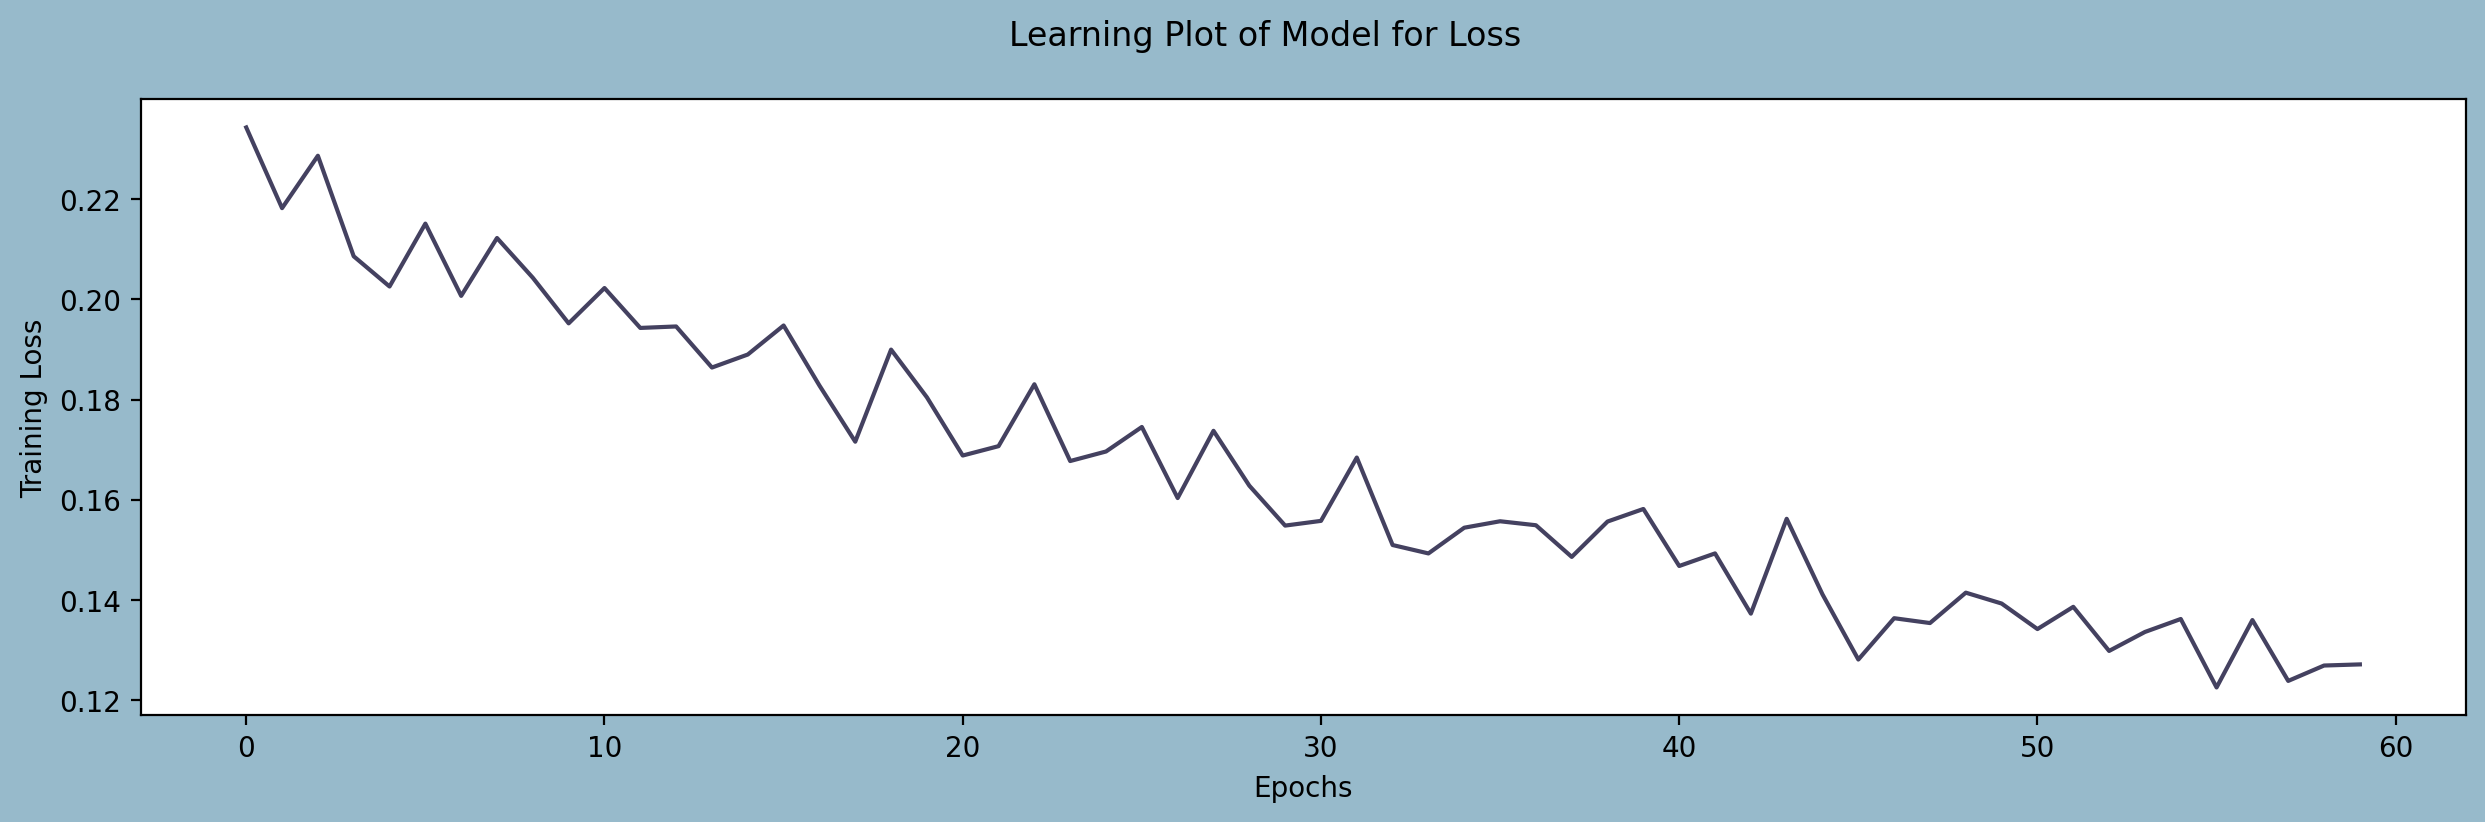

In [ ]:
#Plotting the learnings
history_df = pd.DataFrame(history.history)
fig = plt.figure(figsize=(15,4), facecolor="#97BACB")
fig.suptitle("Learning Plot of Model for Loss")
pl=sns.lineplot(data=history_df["loss"],color="#444160")
pl.set(ylabel ="Training Loss")
pl.set(xlabel ="Epochs")

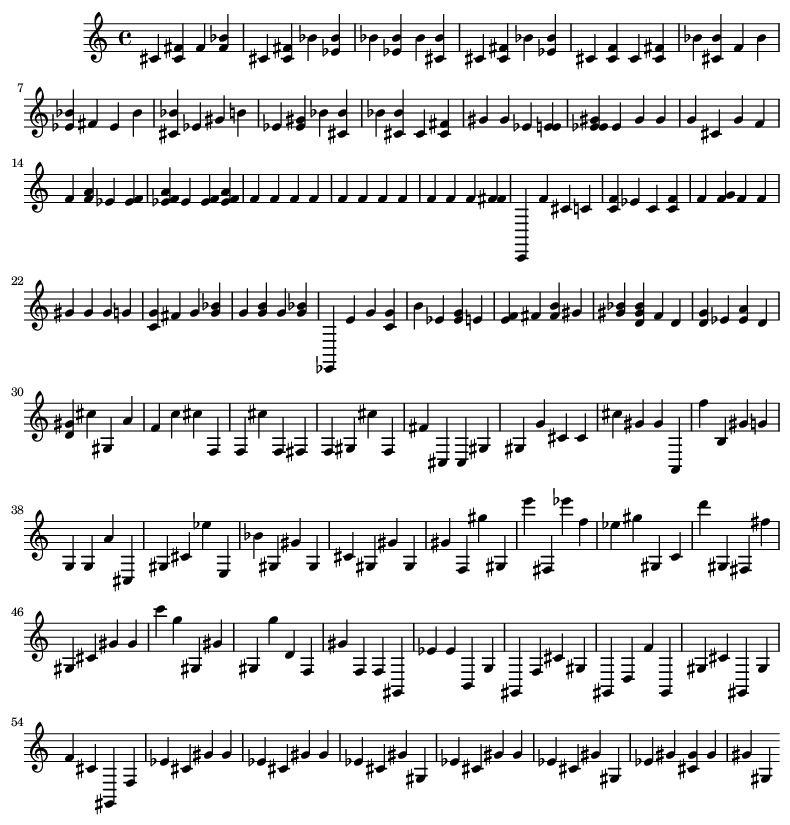

'Melody_Generated.mid'

In [ ]:
def Malody_Generator(Note_Count):
    seed = X_seed[np.random.randint(0,len(X_seed)-1)]
    Music = ""
    Notes_Generated=[]
    for i in range(Note_Count):
        seed = seed.reshape(1,length,1)
        prediction = model.predict(seed, verbose=0)[0]
        prediction = np.log(prediction) / 1.0 #diversity
        exp_preds = np.exp(prediction)
        prediction = exp_preds / np.sum(exp_preds)
        index = np.argmax(prediction)
        index_N = index/ float(L_symb)
        Notes_Generated.append(index)
        Music = [reverse_mapping[char] for char in Notes_Generated]
        seed = np.insert(seed[0],len(seed[0]),index_N)
        seed = seed[1:]
    #Now, we have music in form or a list of chords and notes and we want to be a midi file.
    Melody = chords_n_notes(Music)
    Melody_midi = stream.Stream(Melody)
    return Music,Melody_midi

#getting the Notes and Melody created by the model
Music_notes, Melody = Malody_Generator(200)
show(Melody)
#To save the generated melody
Melody.write('mid','Melody_Generated.mid')

In [ ]:
!pip install midi2audio

In [ ]:
!pip install FluidSynth

  Preparing metadata (setup.py) ... done
  Created wheel for FluidSynth: filename=fluidsynth-0.2-py3-none-any.whl size=4487 sha256=3b2a1d4c8acc6733069c8a3abd3a7d3044882db440d73c37c1b36af74b242f89
  Stored in directory: /root/.cache/pip/wheels/72/5a/bf/347b142f199fb1bea87f16f8970916226951bc359c947ba19b
Successfully built FluidSynth


In [ ]:
from midi2audio import FluidSynth
import os

def convert_midi_to_mp3(midi_file, output_mp3):
    # Replace 'soundfont.sf2' with the path to a SoundFont file on your system
    soundfont_path = 'soundfont.sf2'

    fs = FluidSynth(soundfont_path)

if __name__ == "__main__":
    midi_file_path = '/content/Melody_Generated.mid'
    output_mp3_path = '/content/Melody_Generated.mp3'

    convert_midi_to_mp3(midi_file_path, output_mp3_path)

    print(f"Conversion completed. MP3 file saved at: {output_mp3_path}")


Conversion completed. MP3 file saved at: /content/Melody_Generated.mp3
